# Importing the data

## Import stuff

In [1]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = 'Bird Species Dataset' 
#the code file should be in the same folder as the folder called 'Bird Species Dataset' thus this is the path to the folder containing the dataset
filepaths, image_list, label_list = [], [], []

folders = os.listdir(data_dir)

#print(folders)

for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        label_list.append(fold)

print(filepaths)
print(label_list)

for file in filepaths:
    image = cv2.imread(file)
    image = img_to_array(image)
    image_list.append(image)
    
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(label_list, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

['Bird Species Dataset\\AMERICAN GOLDFINCH\\001.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\002.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\003.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\004.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\005.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\006.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\007.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\008.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\009.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\010.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\011.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\012.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\013.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\014.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\015.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\016.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\017.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\018.jpg', 'Bird Species Dataset\\AMERICAN GOLDFINCH\\01

In [3]:
df['labels'].value_counts()

labels
AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
Name: count, dtype: int64

In [22]:
np.shape(image_list)

(811, 224, 224, 3)

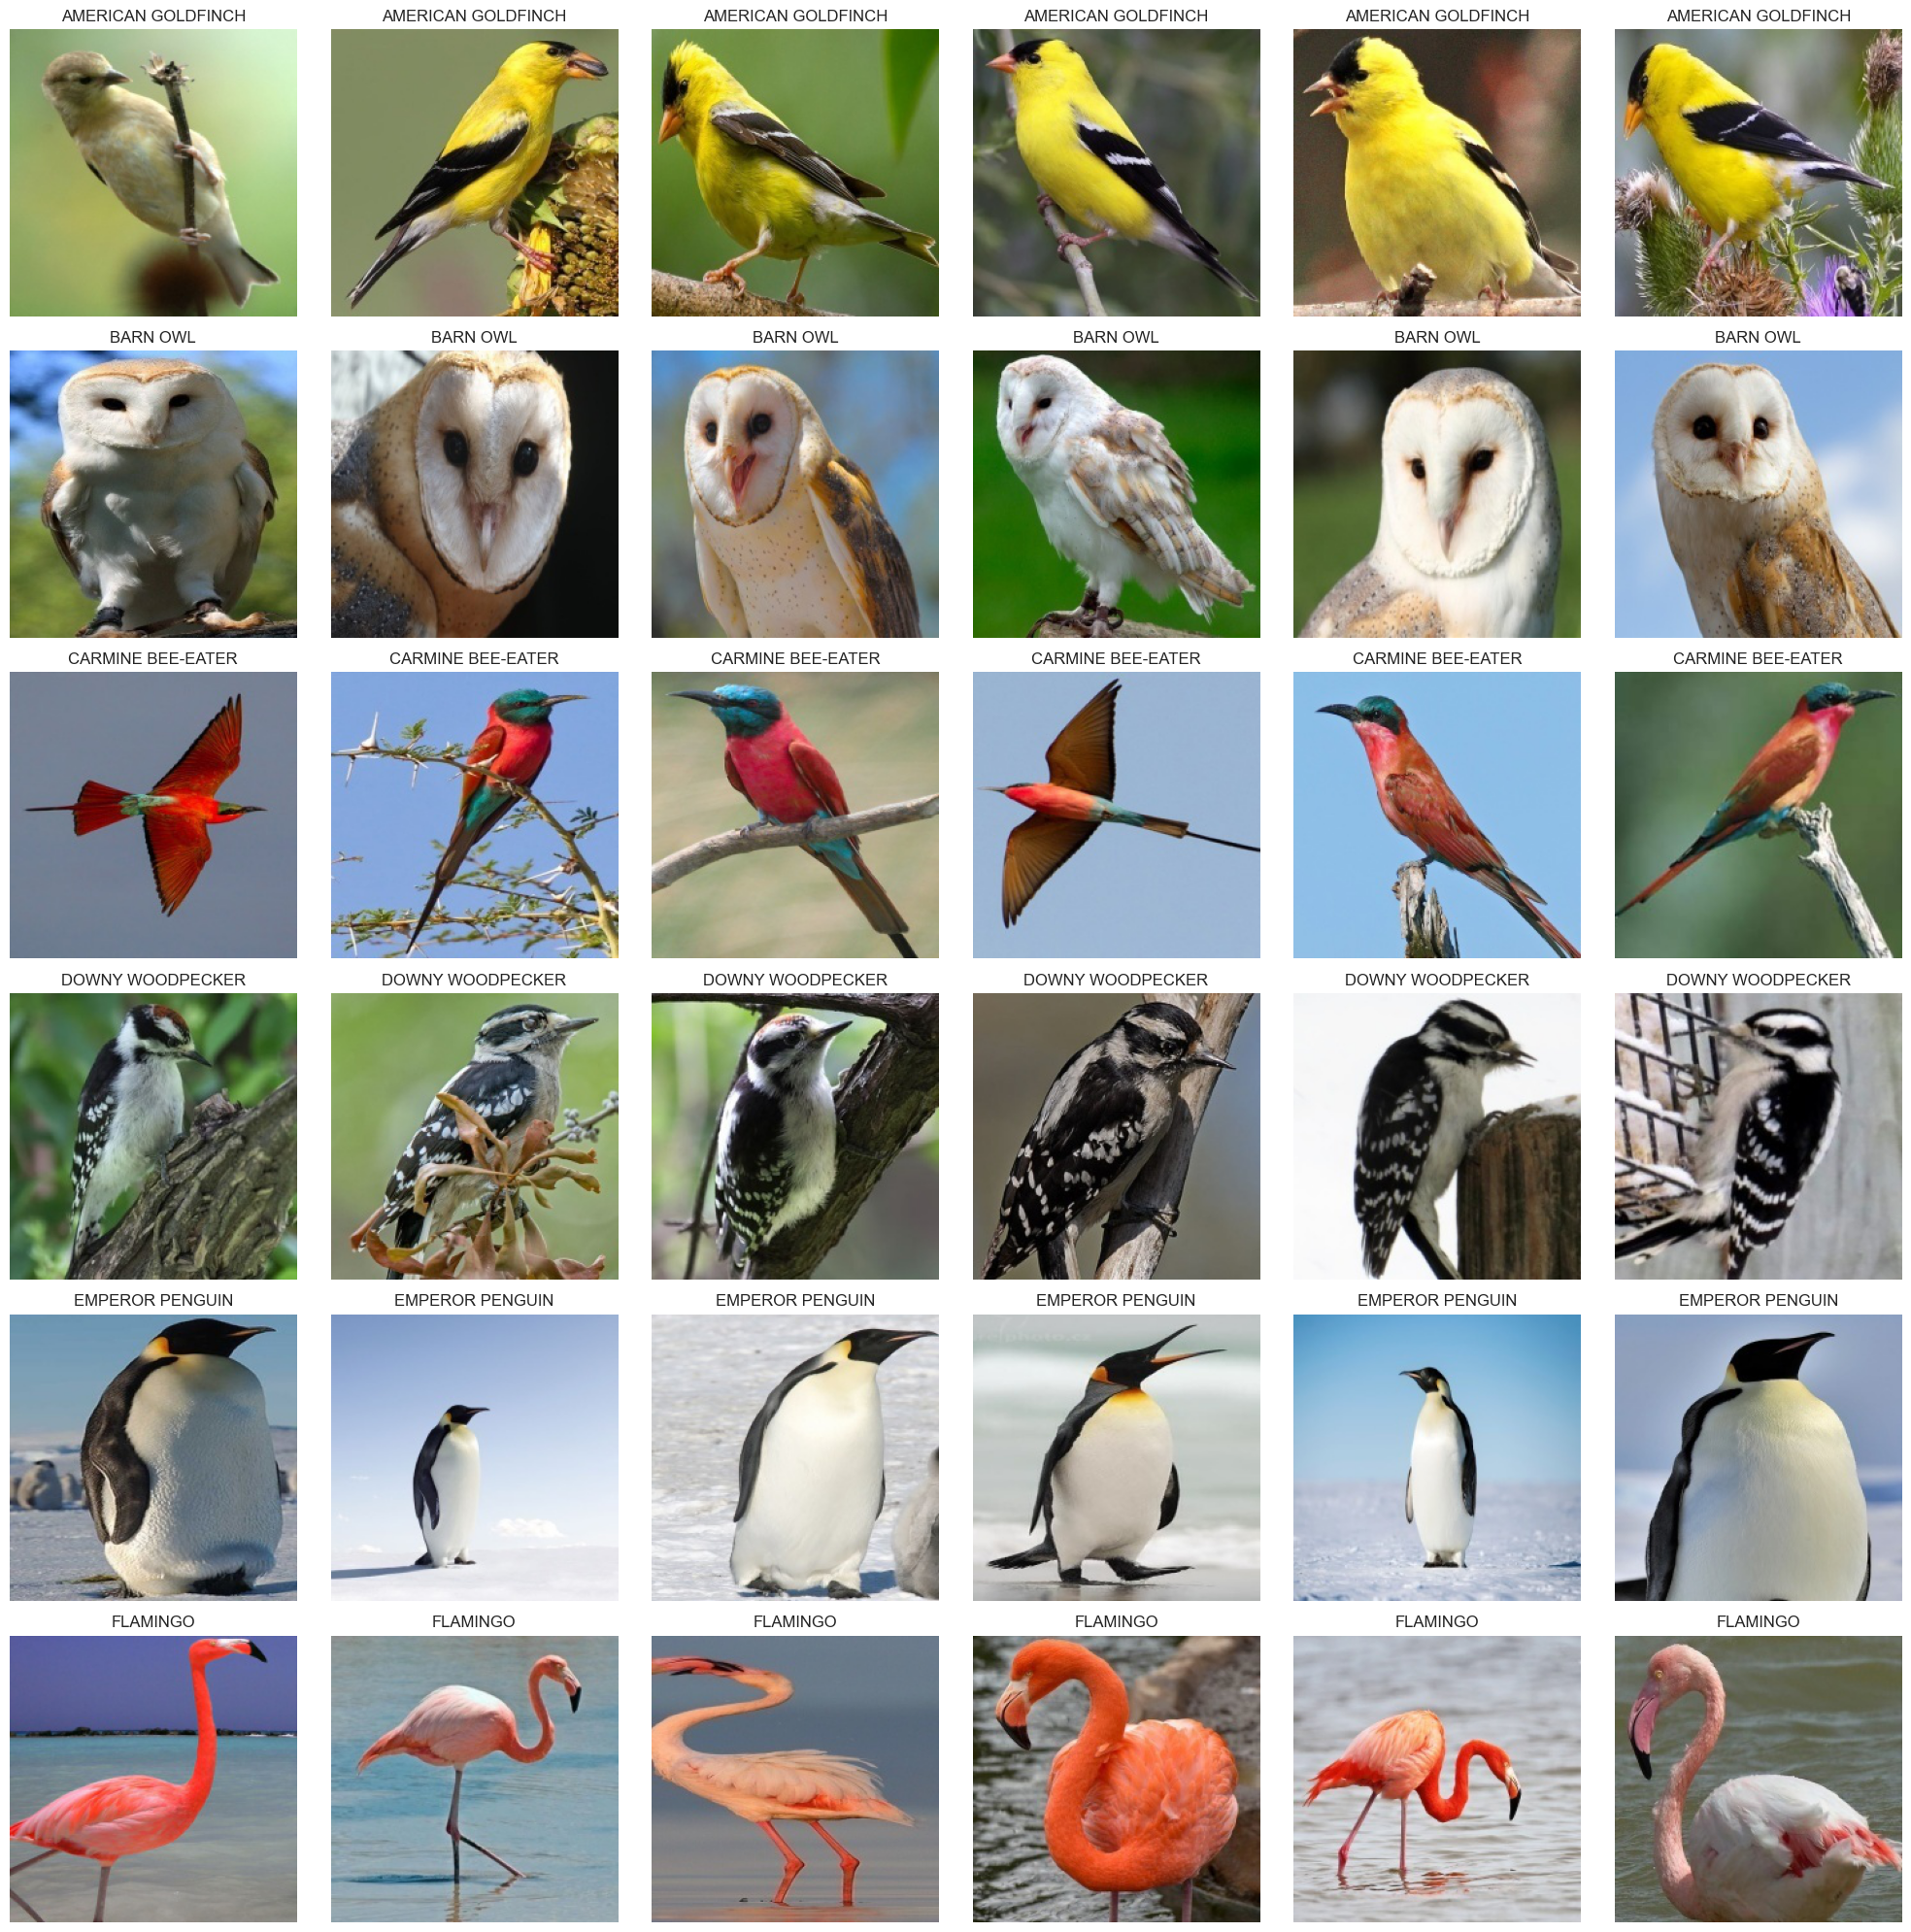

In [23]:
num_images = 6

# Get unique bird species labels
bird_species = df['labels'].unique()

# Set up the plot
plt.figure(figsize=(20, 20))

# Loop through each bird species
for idx, bird in enumerate(bird_species):
    # Filter the DataFrame to get file paths for this bird species
    bird_df = df[df['labels'] == bird].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(bird_df['filepaths'].values):
        plt.subplot(len(bird_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(bird)
        
# Show the plot
plt.tight_layout()
plt.show()

In [30]:
# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.3, shuffle=True, stratify=strat, random_state=123)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.5, shuffle=True, stratify=strat, random_state=123)


print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

Number of Training dataset: 567
Number of Validation dataset: 122
Number of Testing dataset: 122


In [31]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle= True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


print(tr_gen)

Found 567 validated image filenames belonging to 6 classes.
Found 122 validated image filenames belonging to 6 classes.
Found 122 validated image filenames belonging to 6 classes.


In [32]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [34]:
def load_model():
    model = Sequential([
        Flatten(input_shape = img_shape),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(class_count, activation='softmax')
    ])
    
    model.compile(Adamax(learning_rate=.0005), loss = 'categorical_crossentropy', metrics=['acc'])
    
    return model



early_stopping = EarlyStopping(
    patience=10,
    min_delta=0,
    mode=min,
    monitor='val_loss',
    verbose=0,
    restore_best_weights=True,
    baseline=None
)



plateau = ReduceLROnPlateau(
    patience=4,
    mode=min,
    monitor='val_loss',
    factor=.2,
    verbose=0
)



ann_model = load_model()
history = ann_model.fit(x= train_gen, verbose=1, validation_data=valid_gen,
                        shuffle=False, epochs=5, callbacks=[early_stopping, plateau])

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - acc: 0.2043 - loss: 3576.5193 - val_acc: 0.3934 - val_loss: 414.3617 - learning_rate: 5.0000e-04
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 23s 317ms/step - acc: 0.4376 - loss: 636.1453 - val_acc: 0.4426 - val_loss: 635.7184 - learning_rate: 5.0000e-04
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - acc: 0.5156 - loss: 437.2833 - val_acc: 0.4754 - val_loss: 593.8038 - learning_rate: 5.0000e-04
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 311ms/step - acc: 0.5674 - loss: 313.9025 - val_acc: 0.5984 - val_loss: 343.8402 - learning_rate: 5.0000e-04
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 315ms/step - acc: 0.6168 - loss: 208.6502 - val_acc: 0.6148 - val_loss: 342.3302 - learning_rate: 5.0000e-04
